# Clustering with Statistical Features #

## Import Statements ##

In [1]:
import numpy as np
from scipy import stats
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import os
import glob
import pandas as pd
from astropy.io import fits
import random
import math
# import umap
# conda activate myenv
#/home/pdong/.conda/envs/myenv


## Get the light curve data ##

In [2]:
# Path to the directory containing the FITS files
data_dir = '/pool001/rarcodia/eROSITA_public/data/eRASS1_lc_rebinned'

def read_inaccessible_lightcurves():
    """
    Read the list of inaccessible light curves from the text file in the notebook directory.
    
    Returns:
        list: List of file paths that were inaccessible
    """
    file_path = os.path.join(os.getcwd(), "inaccessible_lightcurves.txt")
    
    try:
        with open(file_path, 'r') as f:
            # Read all lines and remove any trailing whitespace
            inaccessible_files = [line.strip() for line in f.readlines()]
        return inaccessible_files
    except FileNotFoundError:
        print(f"No inaccessible light curves file found at {file_path}")
        return []

# Function to load a single FITS file and return as a Pandas DataFrame
def load_light_curve(file_path, band=1):
    """
    Load light curve data from a FITS file and return a Pandas DataFrame including asymmetric errors (ERRM and ERRP).

    Parameters:
        file_path (str): Path to the FITS file.
        band (int): Energy band index to load data for (default: 1).

    Returns:
        pd.DataFrame or None: DataFrame with light curve data, or None if file is skipped.
    """
    with fits.open(file_path) as hdul:
        data = hdul[1].data  # Assuming light curve data is in the second HDU
        try:
            light_curve = pd.DataFrame({
                'TIME': data['TIME'],
                'TIMEDEL': data['TIMEDEL'],
                'RATE': data['RATE'][:, band],  # Light curve intensity
                'ERRM': data['RATE_ERRM'][:, band],  # Negative error
                'ERRP': data['RATE_ERRP'][:, band],  # Positive error
                'SYM_ERR': (data['RATE_ERRM'][:, band] + data['RATE_ERRP'][:, band]) / 2,  # Symmetric error approximation
                'OUTLIER': False  # Mark as False initially - TODO: Add as an atribute
            })
            # Attach metadata as attributes
            light_curve.attrs['FILE_NAME'] = os.path.basename(file_path)
            return light_curve
        except KeyError:
            print(f"Skipping file {file_path}: some key not found")
            return None

    

def load_all_fits_files(data_dir = '/pool001/rarcodia/eROSITA_public/data/eRASS1_lc_rebinned'):
    """
    Loads all fits files
    
    Parameters:
        data_dir (str): The filepath where the data is located
        
    Returns:
        fits_files (list): A list of all the fits files
    """
    
    return glob.glob(os.path.join(data_dir, "*.fits"))

def load_n_light_curves(n, fits_files, band = 'all'):
    """
    Loads a specified amount of light curves to analyze.
    
    Parameters:
        n (int): Number of light curves to load.
        fits_files (list): A list of all the fits files
        
    Returns:
        light_curves_1 (list): A list of n light curves in 0.2-0.6 keV,
        light_curves_2 (list): A list of n light curves in 0.6-2.3keV
        light_curves_3 (list): A list of n light curves in 2.3-5.0keV
    """
    

    # Randomly select n files
    inaccess_files = read_inaccessible_lightcurves()

    # Randomly select n files
    fits_files = random.sample(fits_files, n)
    
    temp = []
    for lc in  fits_files:
        if lc not in inaccess_files:
            temp.append(lc)
    fits_files = temp
    
    # Load all bands of the light curves into a list of DataFrames
    if band == 'all':
        light_curves_1 = [df for df in (load_light_curve(file, band = 0) for file in fits_files) if df is not None]
        light_curves_2 = [df for df in (load_light_curve(file, band = 1) for file in fits_files) if df is not None]
        light_curves_3 = [df for df in (load_light_curve(file, band = 2) for file in fits_files) if df is not None]
    
        return light_curves_1, light_curves_2, light_curves_3
    elif band == 'low':
        light_curves_1 = [df for df in (load_light_curve(file, band = 0) for file in fits_files) if df is not None]
        return light_curves_1
    elif band == 'med':
        light_curves_2 = [df for df in (load_light_curve(file, band = 1) for file in fits_files) if df is not None]
        return light_curves_2
    elif band == 'high':
        light_curves_3 = [df for df in (load_light_curve(file, band = 2) for file in fits_files) if df is not None]
        return light_curves_3
    else:
        raise KeyError("Input for Band is not valid")
        
    

def load_all_light_curves(fits_files):
    """
    Loads a specified amount of light curves to analyze.
    
    Parameters:
        n (int): Number of light curves to load.
        fits_files (list): A list of all the fits files
        
    Returns:
        light_curves_1 (list): A list of n light curves in 0.2-0.6 keV,
        light_curves_2 (list): A list of n light curves in 0.6-2.3keV
        light_curves_3 (list): A list of n light curves in 2.3-5.0keV
    """
    
    inaccess_files = read_inaccessible_lightcurves()
    
    temp = []
    for lc in  fits_files:
        if lc not in inaccess_files:
            temp.append(lc)
    fits_files = temp
    
    if band == 'all':
        light_curves_1 = [df for df in (load_light_curve(file, band = 0) for file in fits_files) if df is not None]
        light_curves_2 = [df for df in (load_light_curve(file, band = 1) for file in fits_files) if df is not None]
        light_curves_3 = [df for df in (load_light_curve(file, band = 2) for file in fits_files) if df is not None]
    
        return light_curves_1, light_curves_2, light_curves_3
    elif band == 'low':
        light_curves_1 = [df for df in (load_light_curve(file, band = 0) for file in fits_files) if df is not None]
        return light_curves_1
    elif band == 'med':
        light_curves_2 = [df for df in (load_light_curve(file, band = 1) for file in fits_files) if df is not None]
        return light_curves_2
    elif band == 'high':
        light_curves_3 = [df for df in (load_light_curve(file, band = 2) for file in fits_files) if df is not None]
        return light_curves_3
    else:
        raise KeyError("Input for Band is not valid")
    


In [3]:
fits_files = load_all_fits_files()
print(len(fits_files))

light_curves_2 = load_n_light_curves(10000, fits_files, band = "med")
# light_curves_1_all, light_curves_2_all, light_curves_3_all = load_all_light_curves(fits_files)
# light_curves_1_100, light_curves_2_100, light_curves_3_100 = load_n_light_curves(100, fits_files)
# light_curves_1_400, light_curves_2_400, light_curves_3_400 = load_n_light_curves(400, fits_files)
# light_curves_1_1000, light_curves_2_1000, light_curves_3_1000 = load_n_light_curves(1000, fits_files)
# light_curves_1_2000, light_curves_2_2000, light_curves_3_2000 = load_n_light_curves(2000, fits_files)
# light_curves_1_10000, light_curves_2_10000, light_curves_3_10000 = load_n_light_curves(10000, fits_files)
print('Finished Loading Light Curves')

200013
Finished Loading Light Curves


In [4]:
# print(light_curves_2[0])
# print(light_curves_2_1000[0])

## Feature Extraction ##

In [5]:
# Working with list of features
def extract_statistical_features_error(df):
    """
    Extract statistical features from the light curve, accounting for measurement errors,
    and return as a list.

    Parameters:
        df (pd.DataFrame): Light curve DataFrame with 'RATE', 'ERRM', and 'ERRP'.

    Returns:
        list: List of extracted features.
    """
    # Weighted Mean (Symmetric Errors)
    weights = 1 / df['SYM_ERR']**2  # Inverse variance weighting
    weighted_mean = np.sum(df['RATE'] * weights) / np.sum(weights)

    # Weighted Variance
    weighted_variance = np.sum(weights * (df['RATE'] - weighted_mean)**2) / np.sum(weights)
    

    # Robust Statistics
    median = np.median(df['RATE'])
    iqr = np.percentile(df['RATE'], 75) - np.percentile(df['RATE'], 25)

    # Beyond 1 sigma (error-aware)
    beyond_1_sigma = np.sum(np.abs(df['RATE'] - weighted_mean) > np.sqrt(weighted_variance)) / len(df['RATE'])

    # Median Absolute Deviation (MAD) (rank-based, no error weighting)
    mad = stats.median_abs_deviation(df['RATE'])
    
    # Skewness and Kurtosis
    # skewness = ((df['RATE'] - weighted_mean)**3 * weights).sum() / (weights.sum() * weighted_variance**1.5)
    # kurtosis = ((df['RATE'] - weighted_mean)**4 * weights).sum() / (weights.sum() * weighted_variance**2)

    # Additional Features
    max_rate = df['RATE'].max()
    min_rate = df['RATE'].min()
    max_amp = max_rate - min_rate
    
    # Flux Percentile Ratio (95th - 5th percentile)
    flux_percentile_ratio = np.percentile(df['RATE'], 95) - np.percentile(df['RATE'], 5)
    
    
    
    # Return features as a list
    return [
        weighted_mean,
        weighted_variance,
        median,
        iqr,
        beyond_1_sigma,
        mad,
        # skewness,
        # kurtosis,
        max_amp,
        flux_percentile_ratio
    ]

def process_all_light_curves_error(light_curves):
    """Process a list of DataFrames containing light curve data"""
    features_list = []
    for lc in light_curves:
        features_list.append(extract_statistical_features_error(lc))
    return np.array(features_list, dtype=np.float64)


In [6]:
# Working with Dataframes Instead
def df_extract_statistical_features_error(df):
    """
    Extract statistical features from the light curve, accounting for measurement errors,
    and return as a single-row DataFrame.

    Parameters:
        df (pd.DataFrame): Light curve DataFrame with 'RATE', 'ERRM', and 'ERRP'.

    Returns:
        pd.DataFrame: A DataFrame containing 'file_path', 'feature_names', and 'feature_values'.
    """
    # Weighted Mean (Symmetric Errors)
    weights = 1 / df['SYM_ERR']**2  # Inverse variance weighting
    weighted_mean = np.sum(df['RATE'] * weights) / np.sum(weights)

    # Weighted Variance
    weighted_variance = np.sum(weights * (df['RATE'] - weighted_mean)**2) / np.sum(weights)

    # Robust Statistics
    median = np.median(df['RATE'])
    iqr = np.percentile(df['RATE'], 75) - np.percentile(df['RATE'], 25)

    # Beyond 1 sigma (error-aware)
    beyond_1_sigma = np.sum(np.abs(df['RATE'] - weighted_mean) > np.sqrt(weighted_variance)) / len(df['RATE'])

    # Median Absolute Deviation (MAD)
    mad = stats.median_abs_deviation(df['RATE'])

    # Skewness and Kurtosis
    # skewness = ((df['RATE'] - weighted_mean)**3 * weights).sum() / (weights.sum() * weighted_variance**1.5)
    # kurtosis = ((df['RATE'] - weighted_mean)**4 * weights).sum() / (weights.sum() * weighted_variance**2)

    # Additional Features
    max_rate = df['RATE'].max()
    min_rate = df['RATE'].min()
    max_amp = max_rate - min_rate

    # Flux Percentile Ratio (95th - 5th percentile)
    flux_percentile_ratio = np.percentile(df['RATE'], 95) - np.percentile(df['RATE'], 5)

    # Create a row with features
    # feature_names = [
    #     "weighted_mean", "weighted_variance", "median", "iqr", "beyond_1_sigma", 
    #     "mad", "skewness", "kurtosis", "max_amp", "flux_percentile_ratio"
    # ]
    feature_names = [
        "weighted_mean", "weighted_variance", "median", "iqr", "beyond_1_sigma", 
        "mad", "max_amp", "flux_percentile_ratio"
    ]
    # feature_values = np.array([
    #     weighted_mean, weighted_variance, median, iqr, beyond_1_sigma, 
    #     mad, skewness, kurtosis, max_amp, flux_percentile_ratio
    # ])
    feature_values = np.array([
        weighted_mean, weighted_variance, median, iqr, beyond_1_sigma, 
        mad, max_amp, flux_percentile_ratio
    ])
    
    # Create the DataFrame row
    return pd.DataFrame({
        "file_path": [df.attrs['FILE_NAME']],
        "feature_names": [feature_names],
        "feature_values": [feature_values]
    })

def df_process_all_light_curves_error(light_curves):
    """
    Process a list of DataFrames containing light curve data and combine results.

    Parameters:
        light_curves (list of pd.DataFrame): List of light curve DataFrames.

    Returns:
        pd.DataFrame: Combined DataFrame with 'file_path', 'feature_names', and 'feature_values'.
    """
    features_list = []
    for lc in light_curves:
        features_list.append(df_extract_statistical_features_error(lc))
    
    # Concatenate all rows into a single DataFrame
    return pd.concat(features_list, ignore_index=True)

In [7]:
# testing block
# features = process_all_light_curves_error(light_curves_2)
# features_df = df_process_all_light_curves_error(light_curves_2)
# print(features[0])
# print(features_df)
# for lc in features:
#     for point in range(len(lc)):
#         if np.isnan(lc[point]):
#             print(point)
# print('done')

## Feature Standardization ##

In [8]:
def detect_outliers(features, contamination=0.1):
    # Scale features
    scaler = RobustScaler()
    scaled_features = scaler.fit_transform(features)
    
    # Use multiple outlier detection methods
    iso_forest = IsolationForest(contamination=contamination, random_state=42)
    lof = LocalOutlierFactor(contamination=contamination, n_neighbors=20)
    
    # Get predictions (-1 for outliers, 1 for inliers)
    iso_pred = iso_forest.fit_predict(scaled_features)
    lof_pred = lof.fit_predict(scaled_features)
    
    # Combine predictions (mark as outlier if either method flags it)
    combined_outliers = (iso_pred == -1) | (lof_pred == -1)
    
    return combined_outliers, scaled_features
# outliers, scaled_features = detect_outliers(features)

In [9]:
# This method works with a features list
def detect_outliers_extreme(features, contamination=0.05):  # Reduced contamination
    # Scale features
    scaler = RobustScaler()
    scaled_features = scaler.fit_transform(features)
    
    # Use multiple outlier detection methods with stricter parameters
    iso_forest = IsolationForest(
        contamination=contamination,
        random_state=42,
        max_samples='auto',
        n_estimators=250  # Increased from default 100
    )
    
    lof = LocalOutlierFactor(
        contamination=contamination,
        n_neighbors=20,
        metric='euclidean',
        p=2,
        novelty=False
    )
    
    # Add IQR method for extreme outliers
    iqr_mult = 5 # 3
    q1 = np.percentile(scaled_features, 25, axis=0)
    q3 = np.percentile(scaled_features, 75, axis=0)
    iqr = q3 - q1
    iqr_outliers = np.any((scaled_features < (q1 - iqr_mult * iqr)) | 
                         (scaled_features > (q3 + iqr_mult * iqr)), axis=1)
    
    # Get predictions
    iso_pred = iso_forest.fit_predict(scaled_features)
    lof_pred = lof.fit_predict(scaled_features)
    
    # Add Z-score method for extreme values
    z_scores = np.abs((scaled_features - np.mean(scaled_features, axis=0)) / 
                     np.std(scaled_features, axis=0))
    z_score_outliers = np.any(z_scores > 4, axis=1)  # Using 4 sigma instead of
    
    # Combine predictions (mark as outlier if both Iso tree and Local Outlier Factor method flags it or if its flaged by iqr and z-score)
    combined_outliers = ((iso_pred == -1) & (lof_pred == -1))  | \
                       (iqr_outliers & z_score_outliers)
    
    
    return combined_outliers, scaled_features

# combined_outliers, scaled_features = detect_outliers_extreme(features)
# print(combined_outliers)


In [10]:
# This method works with a pandas dataframe consisting of more information
def df_detect_outliers_extreme(df, contamination=0.05):
    """
    Detect outliers in rows of a DataFrame, where each row represents a light curve.
    Each row contains:
      - 'file_path': The file path of the light curve
      - 'feature_names': List of feature names
      - 'feature_values': Numpy array of numerical feature values
    
    Args:
    - df (pd.DataFrame): Input DataFrame with light curves.
    - contamination (float): The proportion of data expected to be outliers.
    
    Returns:
    - pd.DataFrame: Original DataFrame with additional columns:
        - 'is_outlier': Boolean flag indicating if the row is an outlier.
        - 'scaled_features': Scaled feature values for further analysis.
        - 'iso_score': Anomaly score from Isolation Forest.
        - 'lof_score': Negative outlier factor from LOF.
        - 'iqr_outlier': Boolean indicating IQR-based outlier.
        - 'z_score_outlier': Boolean indicating Z-score-based outlier.
        - 'combined_outlier': Combined outlier flag across methods.
        - 'outlier_rank': Rank of combined outliers (1 = most outlier-like).
    """
    # Ensure required columns are present
    required_columns = ['file_path', 'feature_names', 'feature_values']
    for col in required_columns:
        if col not in df.columns:
            raise ValueError(f"Missing required column: {col}")
    
    # Prepare features for outlier detection
    feature_matrix = []
    for idx, row in df.iterrows():
        feature_values = row['feature_values']
        if not isinstance(feature_values, np.ndarray):
            raise ValueError(f"Row {idx}: 'feature_values' must be a numpy array.")
        feature_matrix.append(feature_values)
    
    # Convert to numpy array for processing
    feature_matrix = np.vstack(feature_matrix)
    
    # Scale features
    scaler = RobustScaler()
    scaled_features = scaler.fit_transform(feature_matrix)
    
    # Isolation Forest
    iso_forest = IsolationForest(
        contamination=contamination,
        random_state=42,
        max_samples='auto',
        n_estimators=250
    )
    iso_forest.fit(scaled_features)
    iso_pred = iso_forest.predict(scaled_features)
    iso_scores = iso_forest.decision_function(scaled_features)\
    
    # Local Outlier Factor
    lof = LocalOutlierFactor(
        contamination=contamination,
        n_neighbors=20,
        metric='euclidean',
        p=2,
        novelty=False
    )
    lof_scores = lof.fit_predict(scaled_features)
    
    lof_neg_scores = -lof.negative_outlier_factor_  # Higher = more anomalous
    
    # Calculate feature importance using LOF
    feature_importances = []
    num_features = scaled_features.shape[1]
    for i in range(num_features):
        # Remove one feature at a time
        reduced_features = np.delete(scaled_features, i, axis=1)
        
        # Recompute LOF on reduced feature set
        lof_reduced = LocalOutlierFactor(
            contamination=contamination,
            n_neighbors=20,
            metric='euclidean',
            p=2,
            novelty=False
        )
        lof_reduced.fit(reduced_features)
        lof_reduced_neg_scores = -lof_reduced.negative_outlier_factor_
        
        # Measure the difference in LOF scores
        score_difference = np.mean(np.abs(lof_neg_scores - lof_reduced_neg_scores))
        feature_importances.append((df['feature_names'][0][i], score_difference))
    
    # Rank features by importance
    sorted_feature_importances = sorted(
        feature_importances, key=lambda x: x[1], reverse=True
    )
    print(sorted_feature_importances)
    
    # IQR method
    iqr_mult = 5
    q1 = np.percentile(scaled_features, 25, axis=0)
    q3 = np.percentile(scaled_features, 75, axis=0)
    iqr = q3 - q1
    iqr_outliers = np.any(
        (scaled_features < (q1 - iqr_mult * iqr)) |
        (scaled_features > (q3 + iqr_mult * iqr)),
        axis=1
    )
    
    # Z-score method
    z_scores = np.abs((scaled_features - np.mean(scaled_features, axis=0)) /
                      np.std(scaled_features, axis=0))
    z_score_outliers = np.any(z_scores > 4, axis=1)
    
    # Combine outlier predictions
    combined_outliers = (
        ((iso_pred == -1) &
        (lof_scores == -1)) |
        (iqr_outliers &
        z_score_outliers)
    )
    
    # Compute outlier ranks based on Isolation Forest scores for outliers
    outlier_scores = iso_scores[combined_outliers]
    outlier_ranks = pd.Series(outlier_scores).rank(ascending=True).astype(int)
    
    # Add results to DataFrame
    df['scaled_features'] = list(scaled_features)
    df['iso_score'] = iso_scores
    df['lof_score'] = lof_scores  # Negative outlier factor (lower = more anomalous)
    df['iqr_outlier'] = iqr_outliers
    df['z_score_outlier'] = z_score_outliers
    df['combined_outlier'] = combined_outliers
    df['outlier_rank'] = None  # Initialize column with None
    df.loc[combined_outliers, 'outlier_rank'] = outlier_ranks.values
    
    return df


# results = df_detect_outliers_extreme(features_df)
# # print(results.head())
# print(results[results['combined_outlier'] == True])
# print(len(results[results['combined_outlier'] == True]))


# results = df_detect_outliers_extreme(features_df)
# print(results.head())
# print(results[results['is_outlier'] == True])

## Visualize and analyze ##

In [11]:
def visualize_clusters(scaled_features, outliers):
    # Reduce to 2D using PCA
    pca = PCA(n_components=2)
    features_2d = pca.fit_transform(scaled_features)
    
    plt.figure(figsize=(10, 8))
    plt.scatter(features_2d[~outliers, 0], features_2d[~outliers, 1], 
               c='blue', label='Normal', alpha=0.4)
    plt.scatter(features_2d[outliers, 0], features_2d[outliers, 1], 
               c='red', label='Outliers', alpha=0.6)
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.legend()
    plt.title('Light Curves in 2D Feature Space')
    plt.show()

In [12]:
def df_visualize_clusters(scaled_features, combined_outliers):
    """
    Visualize clusters in 2D using PCA, highlighting normal points and outliers.

    Args:
    - scaled_features (np.ndarray): Scaled features of the dataset.
    - combined_outliers (np.ndarray): Boolean array indicating outliers.
    """
    # Reduce to 2D using PCA
    pca = PCA(n_components=2)
    features_2d = pca.fit_transform(scaled_features)
    
    plt.figure(figsize=(10, 8))
    plt.scatter(
        features_2d[~combined_outliers, 0], features_2d[~combined_outliers, 1],
        c='blue', label='Normal', alpha=0.4
    )
    plt.scatter(
        features_2d[combined_outliers, 0], features_2d[combined_outliers, 1],
        c='red', label='Outliers', alpha=0.6
    )
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.legend()
    plt.title('Light Curves in 2D Feature Space')
    plt.show()


## Old functions that I dont care about anymore ##

In [13]:
# def visualize_multiple_clusters(scaled_features_arr, outliers_arr, size=(15, 8)):
#     fig, axes = plt.subplots(1, len(scaled_features_arr), figsize=size)
    
#     for i, ax in enumerate(axes):
#         pca = PCA(n_components=2)
#         features_2d = pca.fit_transform(scaled_features_arr[i])
        
#         ax.scatter(features_2d[~outliers_arr[i], 0], features_2d[~outliers_arr[i], 1], 
#                    c='blue', label='Normal', alpha=0.4)
#         ax.scatter(features_2d[outliers_arr[i], 0], features_2d[outliers_arr[i], 1], 
#                    c='red', label='Outliers', alpha=0.6)
#         ax.set_xlabel('First Principal Component')
#         ax.set_ylabel('Second Principal Component')
#         ax.legend()
#         ax.set_title(f'Light Curves Band {i+1} in 2D Feature Space')
    
#     plt.tight_layout()
#     plt.show()


In [14]:
# # plot multicolored
# def analyze_light_curves_no_outlier(light_curves, contamination=0.05, vis = True):
    # Extract features
#     features = process_all_light_curves(light_curves)
    
#     # Detect outliers
#     outliers, scaled_features, sorted_outliers = detect_outliers_extreme(features)
    
#     if vis:
#         # Visualize results
#         visualize_clusters(scaled_features, outliers)
    
#     return features, outliers, scaled_features, sorted_outliers


In [15]:
# def visualize_multiple_clusters_no_outlier(scaled_features_arr, outliers_arr, n=2000, size = (15, 8)):
#     colors = np.random.rand(n, 3)
#     fig, axes = plt.subplots(1, len(scaled_features_arr), figsize=size)
    
#     for i, ax in enumerate(axes):
#         pca = PCA(n_components=2)
#         features_2d = pca.fit_transform(scaled_features_arr[i])

#         ax.scatter(features_2d[:, 0], features_2d[:, 1], c=colors, alpha=0.8)
#         ax.set_xlabel('First Principal Component')
#         ax.set_ylabel('Second Principal Component')
#         ax.set_title(f'Light Curves {i+1} in 2D Feature Space')
    
#     plt.tight_layout()
#     plt.show()

In [16]:
# visualize_clusters(scaled_features, outliers)

## Completed Pipeline ##

In [17]:
def analyze_light_curves(light_curves, contamination=0.05, vis = True):
    # Extract features
    features = process_all_light_curves_error(light_curves)
    
    # Detect outliers
    outliers, scaled_features = detect_outliers_extreme(features)
    
    if vis:
        # Visualize results
        visualize_clusters(scaled_features, outliers)
    
    return features, outliers, scaled_features

[('beyond_1_sigma', 0.03845603470312451), ('iqr', 0.03630983535393184), ('max_amp', 0.03551182376445861), ('flux_percentile_ratio', 0.028307781225054004), ('weighted_variance', 0.027578797022316918), ('mad', 0.020305507307249813), ('weighted_mean', 0.019615016483003476), ('median', 0.014490723934497983)]


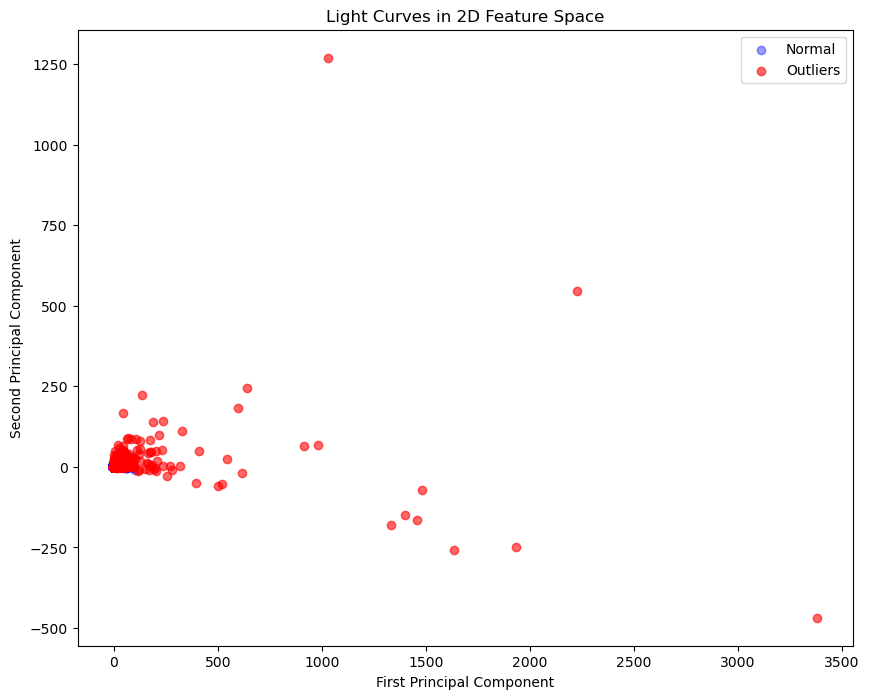

In [18]:
def df_analyze_light_curves(light_curves, contamination=0.05, vis=True):
    """
    Analyze light curves to extract features, detect outliers, and visualize results.

    Args:
    - light_curves (pd.DataFrame): DataFrame containing light curves.
    - contamination (float): Proportion of data expected to be outliers.
    - vis (bool): Whether to visualize the results.

    Returns:
    - pd.DataFrame: DataFrame with extracted features and outlier analysis results.
    """
    # Detect outliers using the provided function
    features = df_process_all_light_curves_error(light_curves)
    results = df_detect_outliers_extreme(features, contamination=contamination)
    
    scaled_features = np.vstack(results['scaled_features'].values)
    combined_outliers = results['combined_outlier'].values

    if vis:
        # Visualize results
        df_visualize_clusters(scaled_features, combined_outliers)
    
    return results
results = df_analyze_light_curves(light_curves_2)

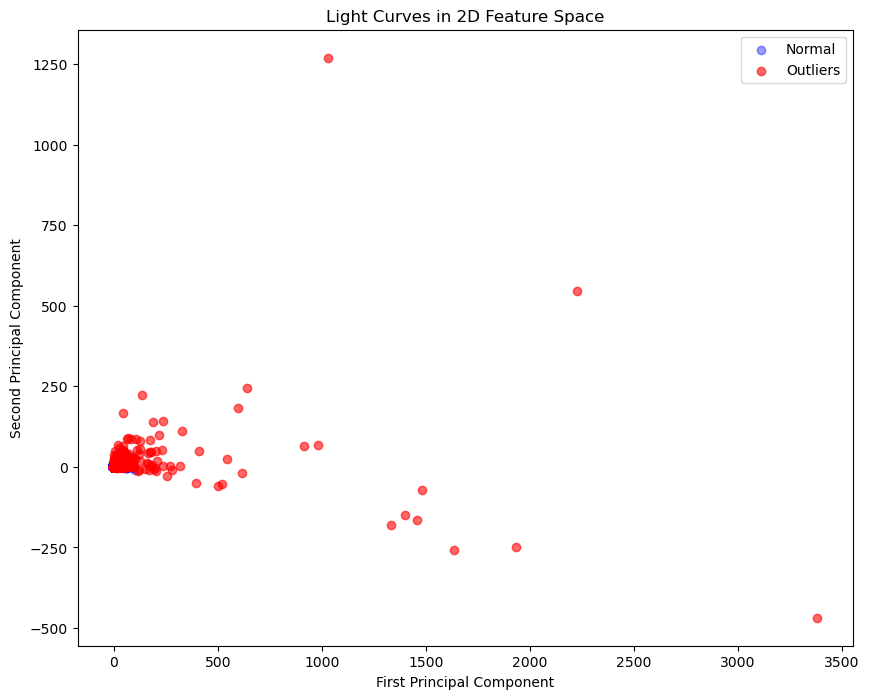

In [19]:
# light_curves_1a, light_curves_2a = load_n_light_curves(10000, fits_files)

# features1, outliers1, scaled_features1 = analyze_light_curves(light_curves_1_1000, vis = True)
# features2, outliers2, scaled_features2 = analyze_light_curves(light_curves_2_1000, vis = False)
# features3, outliers3, scaled_features3 = analyze_light_curves(light_curves_3_1000, vis = False)
features2, outlier2, scaled_features2 = analyze_light_curves(light_curves_2, vis = True)
# visualize_clusters(scaled_features, outliers)

In [20]:
# Which features are the most important?
        # weighted_mean,
        # weighted_variance,
        # median,
        # iqr,
        # beyond_1_sigma,
        # mad,
        # skewness,
        # kurtosis,
        # max_amp,
        # flux_percentile_ratio
# print(importances)

/tmp/ipykernel_25887/3335150681.py:99: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(fontsize='small')


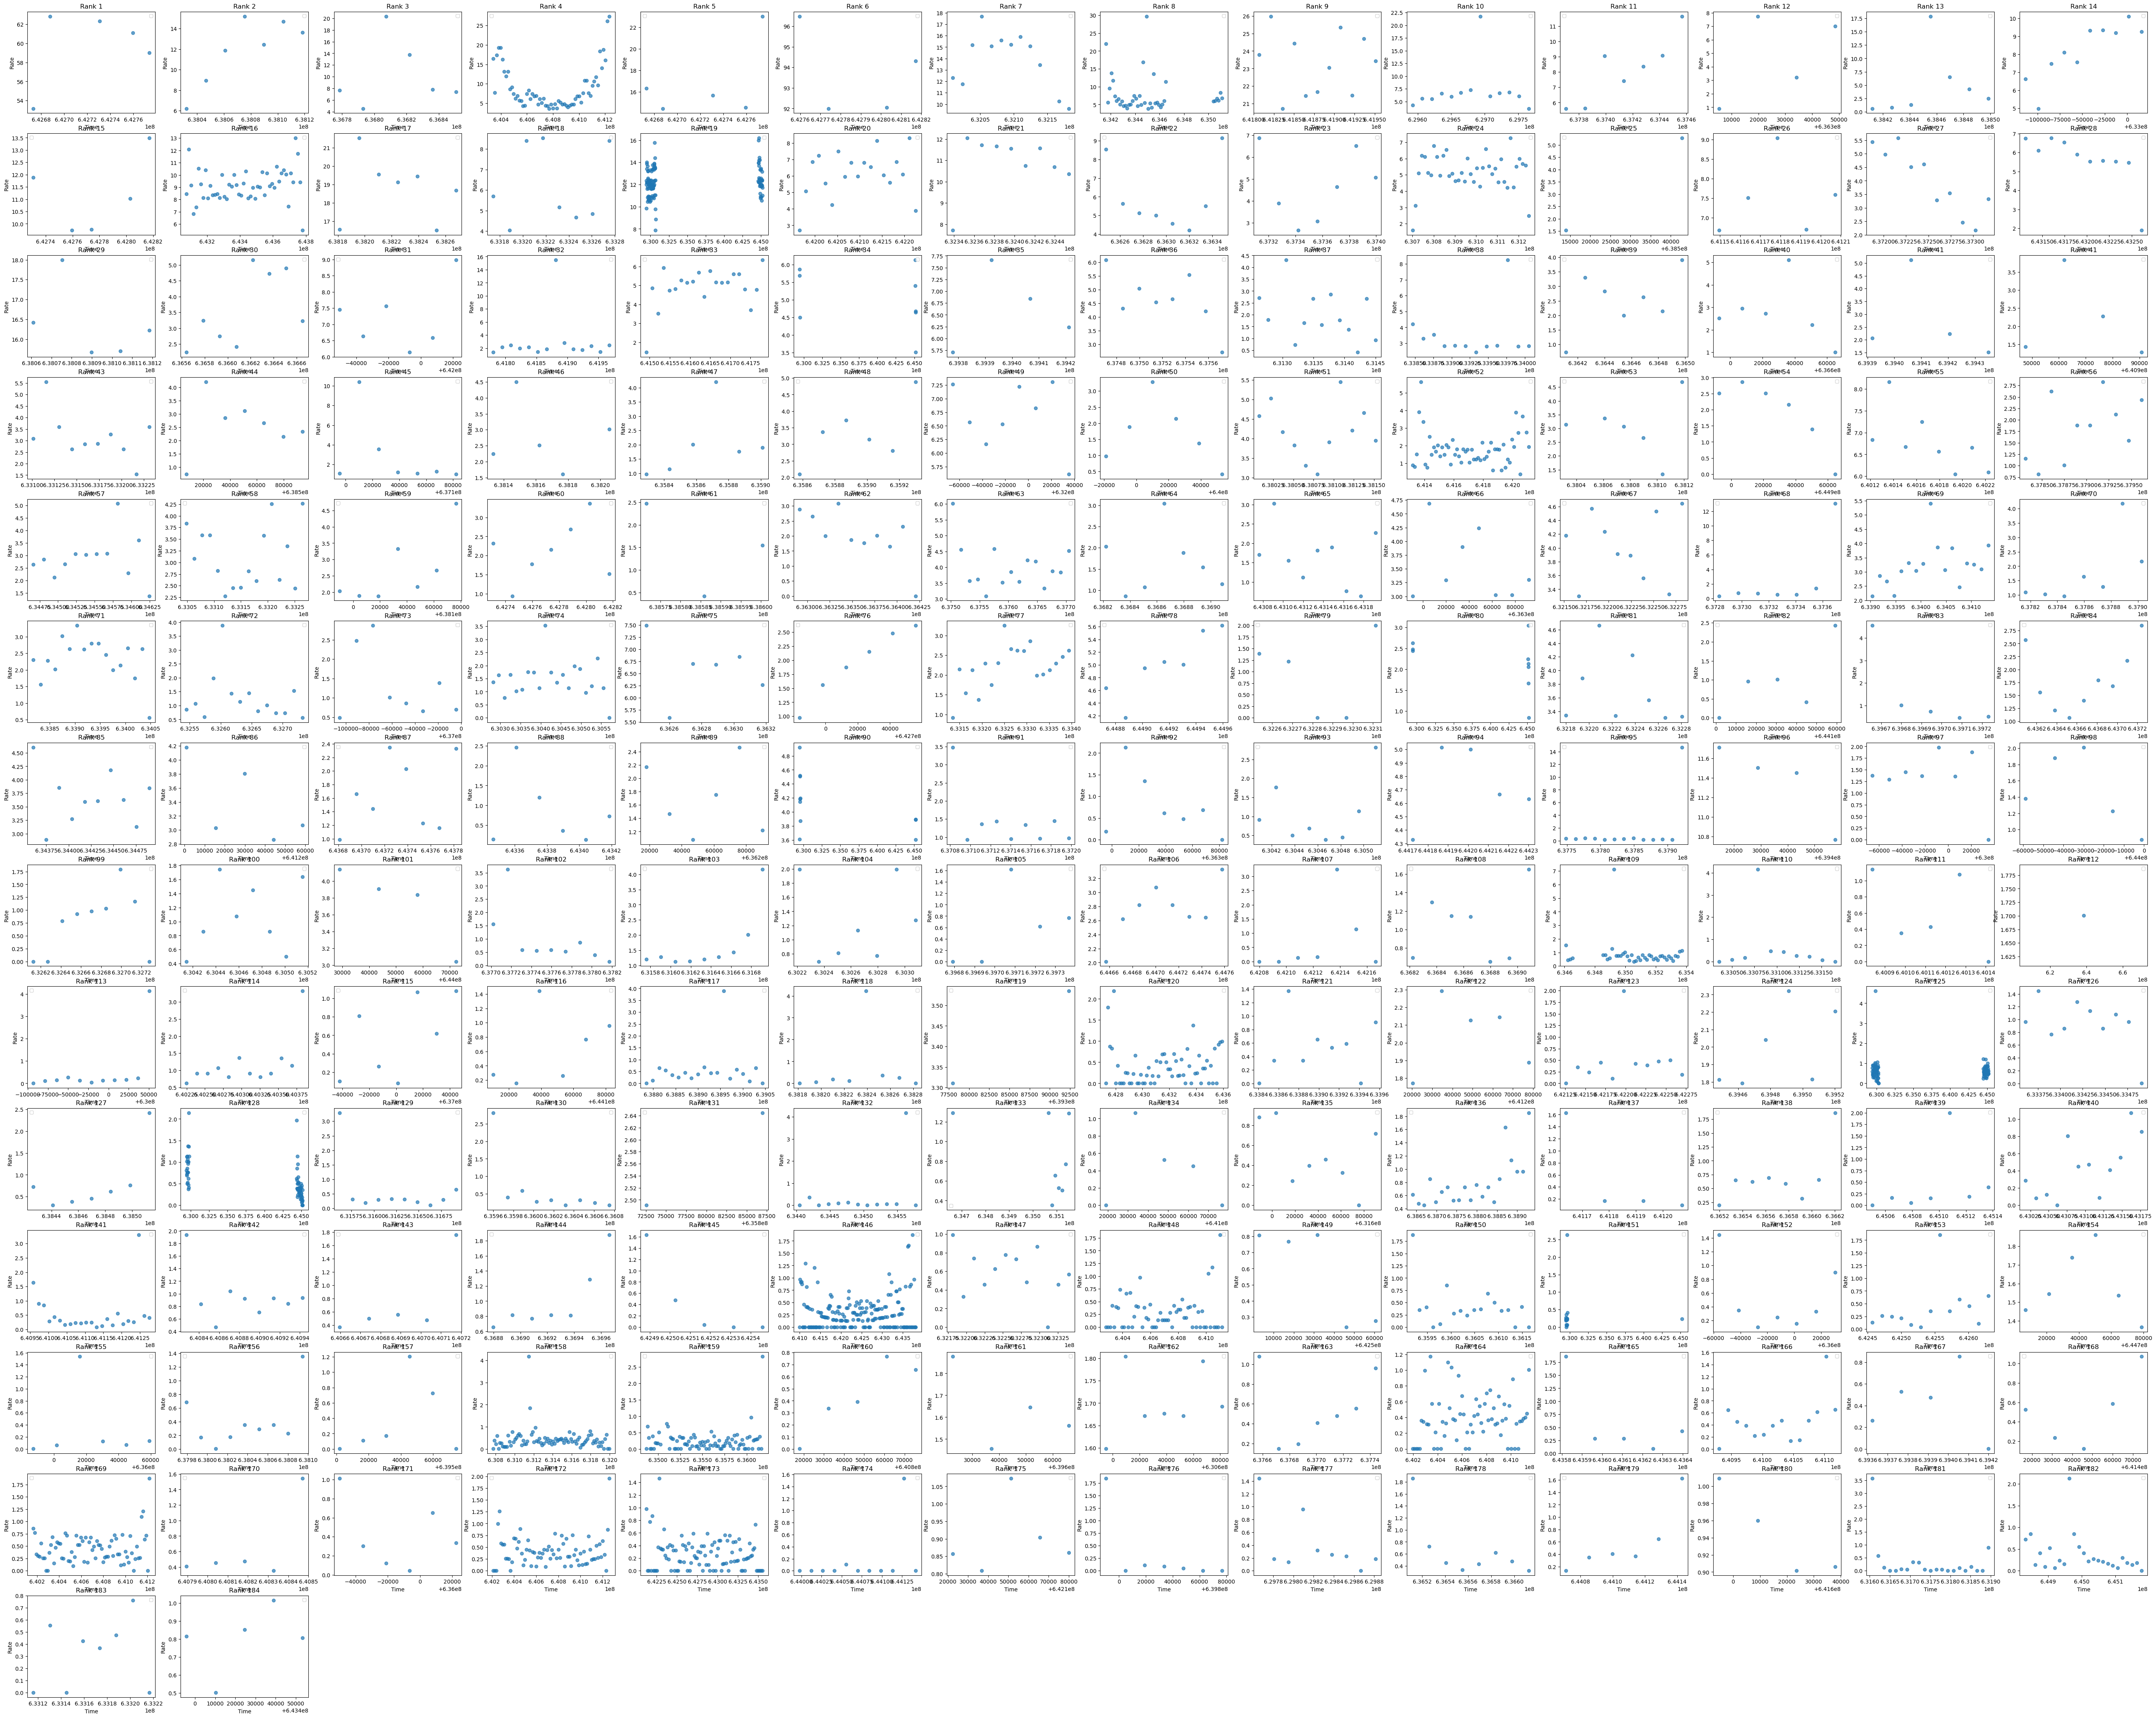

In [21]:
# def plot_outlier_light_curves(results, num_columns=4):
#     """
#     Plots the light curves (RATE vs TIME) for outliers in a square grid ordered by their outlier rank.

#     Args:
#     - results (pd.DataFrame): DataFrame containing results with outliers flagged and ranked.
#     - num_columns (int): Number of columns in the grid. Defaults to 4.
#     """
#     data_dir = '/pool001/rarcodia/eROSITA_public/data/eRASS1_lc_rebinned'
#     # Filter for rows flagged as outliers and sort by outlier rank
#     outliers = results[results['combined_outlier']].sort_values(by='outlier_rank')

#     # Extract relevant file paths
#     outlier_file_paths = outliers['file_path'].tolist()
#     for i, file in enumerate(outlier_file_paths):
#         outlier_file_paths[i] = data_dir + "/" +  file
#     outlier_ranks = outliers['outlier_rank'].tolist()
#     num_outliers = len(outliers)
#     # print(outlier_file_paths[:5])

#     # Determine grid size
#     num_rows = int(np.ceil(num_outliers / num_columns))
#     fig, axes = plt.subplots(num_rows, num_columns, figsize=(num_columns * 5, num_rows * 4))
#     axes = axes.flatten()  # Flatten to easily iterate

#     # Plot each outlier in the grid
#     for idx, (file_path, rank) in enumerate(zip(outlier_file_paths, outlier_ranks)):
#         ax = axes[idx]
        
#         try:
#             # Open the file and read the light curve data
#             # Replace this with the correct method to read your light curve files
#             light_curve = load_light_curve(file_path)  # Assuming the file is in CSV format
            
#             # Ensure 'TIME' and 'RATE' columns exist
#             if 'TIME' not in light_curve.columns or 'RATE' not in light_curve.columns:
#                 raise ValueError(f"'TIME' or 'RATE' column missing in {file_path}")
            
#             # Plot RATE vs TIME
#             ax.scatter(light_curve['TIME'], light_curve['RATE'], label=file_path)
#             ax.set_title(f'Rank {rank}')
#             ax.set_xlabel('Time')
#             ax.set_ylabel('Rate')
#             ax.legend()
#         except Exception as e:
#             ax.text(0.5, 0.5, f"Error: {e}", ha='center', va='center', wrap=True)
#             ax.set_title(f'Rank {rank}: Error')
#             ax.axis('off')
    
#     # Hide remaining empty subplots
#     for ax in axes[num_outliers:]:
#         ax.axis('off')
    
#     plt.tight_layout()
#     plt.show()

def plot_outlier_light_curves(results):
    """
    Plots the light curves (RATE vs TIME) for outliers in a square grid ordered by their outlier rank.

    Args:
    - results (pd.DataFrame): DataFrame containing results with outliers flagged and ranked.
    """
    data_dir = '/pool001/rarcodia/eROSITA_public/data/eRASS1_lc_rebinned'
    
    # Filter for rows flagged as outliers and sort by outlier rank
    outliers = results[results['combined_outlier']].sort_values(by='outlier_rank')

    # Extract relevant file paths
    outlier_file_paths = outliers['file_path'].tolist()
    outlier_file_paths = [f"{data_dir}/{file}" for file in outlier_file_paths]
    outlier_ranks = outliers['outlier_rank'].tolist()
    num_outliers = len(outliers)

    # Determine the smallest square grid size
    grid_size = int(np.ceil(np.sqrt(num_outliers)))
    
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(grid_size * 5, grid_size * 4))
    axes = axes.flatten()  # Flatten to easily iterate through the axes

    # Plot each outlier in the grid
    for idx, (file_path, rank) in enumerate(zip(outlier_file_paths, outlier_ranks)):
        ax = axes[idx]
        try:
            # Open the file and read the light curve data
            light_curve = load_light_curve(file_path)  # Replace this with your file loader
            
            # Ensure 'TIME' and 'RATE' columns exist
            if 'TIME' not in light_curve.columns or 'RATE' not in light_curve.columns:
                raise ValueError(f"'TIME' or 'RATE' column missing in {file_path}")
            
            # Plot RATE vs TIME
            ax.scatter(light_curve['TIME'], light_curve['RATE'], alpha=0.7)
            ax.set_title(f'Rank {rank}')
            ax.set_xlabel('Time')
            ax.set_ylabel('Rate')
            ax.legend(fontsize='small')
        except Exception as e:
            ax.text(0.5, 0.5, f"Error: {e}", ha='center', va='center', wrap=True)
            ax.set_title(f'Rank {rank}: Error')
            ax.axis('off')
    
    # Hide remaining empty subplots
    for ax in axes[num_outliers:]:
        ax.axis('off')
    
    # plt.tight_layout()
    plt.show()
plot_outlier_light_curves(results)

/home/pdong/.conda/envs/myenv/lib/python3.11/site-packages/matplotlib/cbook.py:1709: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)


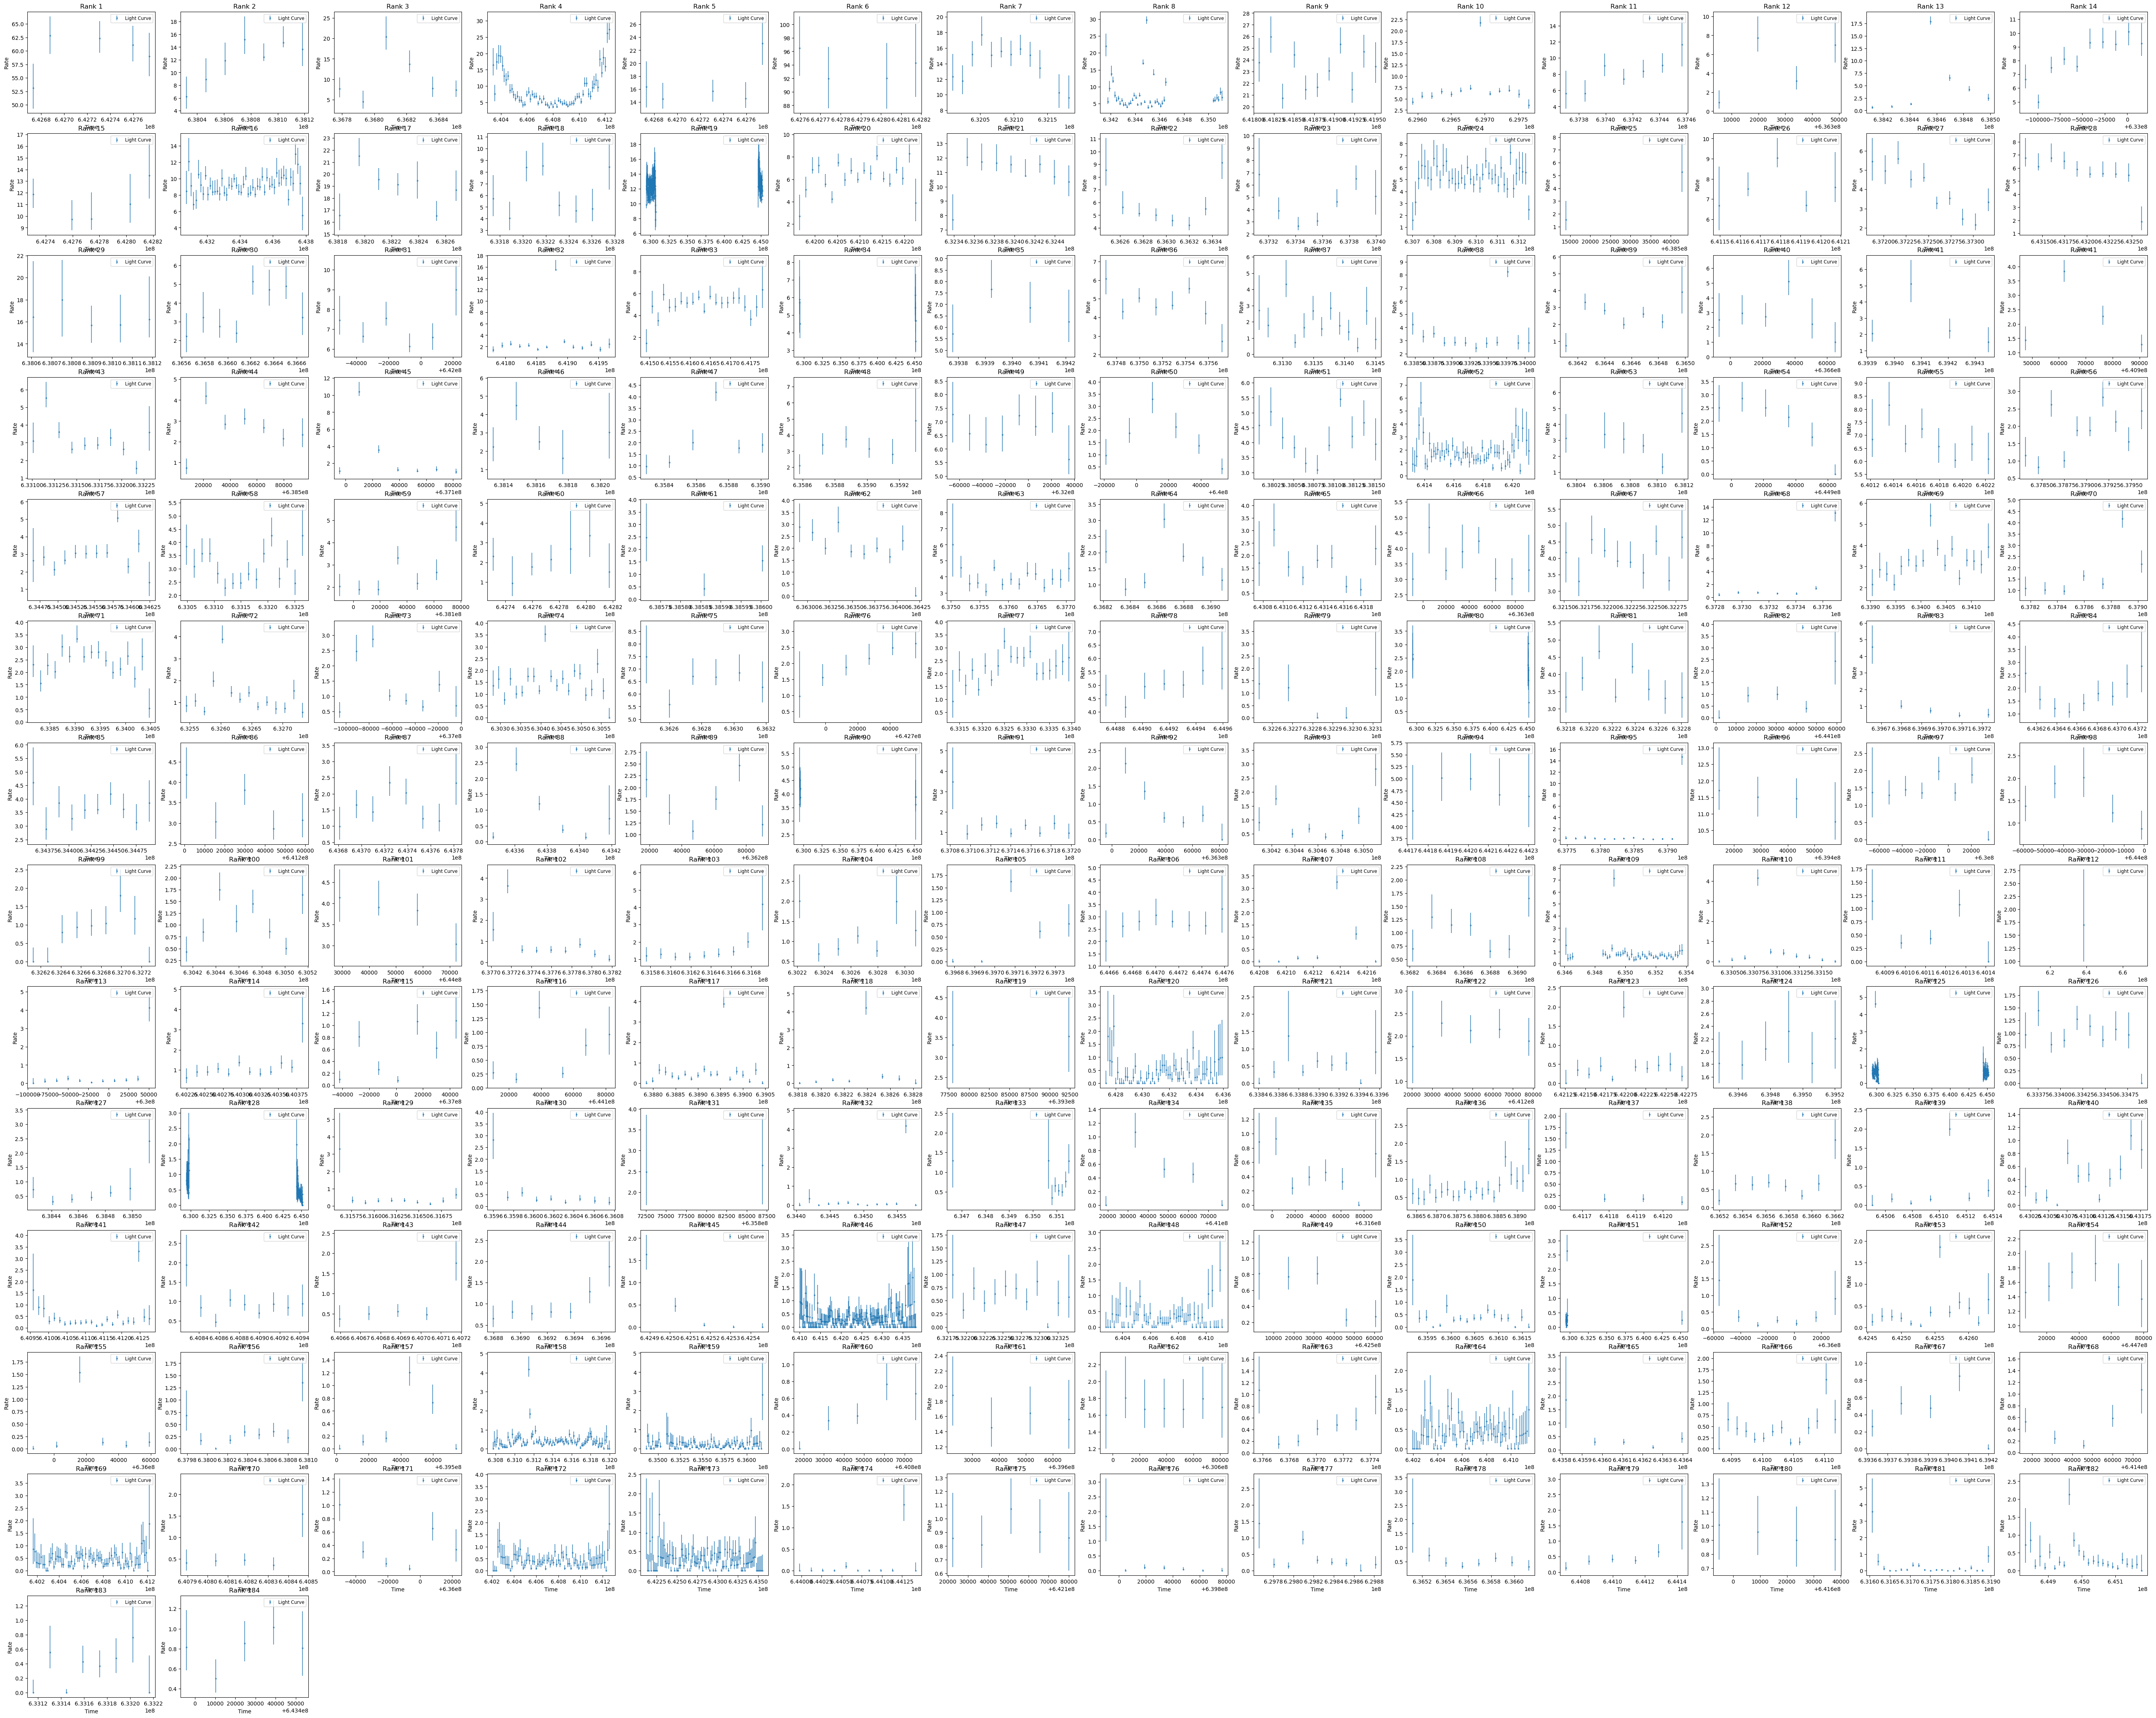

In [25]:
def load_light_curve_error(file_path):
    with fits.open(file_path) as hdul:
        data = hdul[1].data  # Assuming light curve data is in the second HDU
        try:
            # print(data["RATE_ERRM"])
            # print(data["RATE_ERRP"])
            return pd.DataFrame({
                'TIME': data['TIME'],
                'TIMEDEL': data['TIMEDEL'],
                'RATE': data['RATE'][:, 1],  # Use the second energy range
                "RATE_ERRM": data["RATE_ERRM"][:, 1],
                "RATE_ERRP": data["RATE_ERRP"][:, 1]
            })
        except KeyError:
            print(f"Skipping file {file_path}: some key not found")
            return None

def plot_outlier_light_curves_error(results):
    """
    Plots the light curves (RATE vs TIME) for outliers in a square grid ordered by their outlier rank.

    Args:
    - results (pd.DataFrame): DataFrame containing results with outliers flagged and ranked.
    """
    data_dir = '/pool001/rarcodia/eROSITA_public/data/eRASS1_lc_rebinned'
    
    # Filter for rows flagged as outliers and sort by outlier rank
    outliers = results[results['combined_outlier']].sort_values(by='outlier_rank')

    # Extract relevant file paths
    outlier_file_paths = outliers['file_path'].tolist()
    outlier_file_paths = [f"{data_dir}/{file}" for file in outlier_file_paths]
    outlier_ranks = outliers['outlier_rank'].tolist()
    num_outliers = len(outliers)

    # Determine the smallest square grid size
    grid_size = int(np.ceil(np.sqrt(num_outliers)))
    
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(grid_size * 5, grid_size * 4))
    axes = axes.flatten()  # Flatten to easily iterate through the axes

    # Plot each outlier in the grid
    for idx, (file_path, rank) in enumerate(zip(outlier_file_paths, outlier_ranks)):
        ax = axes[idx]
        try:
            # Open the file and read the light curve data
            light_curve = load_light_curve_error(file_path)  # Replace this with your file loader
            
            # Ensure required columns exist
            required_columns = ['TIME', 'RATE', 'RATE_ERRM', 'RATE_ERRP']
            if not all(col in light_curve.columns for col in required_columns):
                raise ValueError(f"One or more required columns missing in {file_path}")

            # Plot RATE vs TIME with error bars
            ax.errorbar(
                light_curve['TIME'], 
                light_curve['RATE'], 
                yerr=[light_curve['RATE_ERRM'], light_curve['RATE_ERRP']],
                fmt='o', markersize=2, alpha=0.7, label='Light Curve'
            )
            ax.set_title(f'Rank {rank}')
            ax.set_xlabel('Time')
            ax.set_ylabel('Rate')
            ax.legend(fontsize='small')
        except Exception as e:
            # Display an error message on the subplot in case of failure
            ax.text(0.5, 0.5, f"Error: {e}", ha='center', va='center', wrap=True)
            ax.set_title(f'Rank {rank}: Error')
            ax.axis('off')
    
    # Hide remaining empty subplots
    for ax in axes[num_outliers:]:
        ax.axis('off')
    
    # plt.tight_layout()
    plt.show()
plot_outlier_light_curves_error(results)

In [22]:
out = []
out_files = []
norm = []
norm_files = []
print(len(light_curves_2))
for i, lc in enumerate(light_curves_2):
    lc['OUTLIER'] = outlier2[i]
    if outlier2[i]:
        out.append(lc)
        out_files.append(lc.attrs['FILE_NAME'])
    else:
        norm.append(lc)
        norm_files.append(lc.attrs["FILE_NAME"])
# print(out[:10])
print(len(out))
# print(light_curves_2[0])

9995
184


## Plot Light Curves ##

/tmp/ipykernel_25887/813166127.py:31: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(x_min - x_margin, x_max + x_margin)
/tmp/ipykernel_25887/813166127.py:32: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(y_min - y_margin, y_max + y_margin)


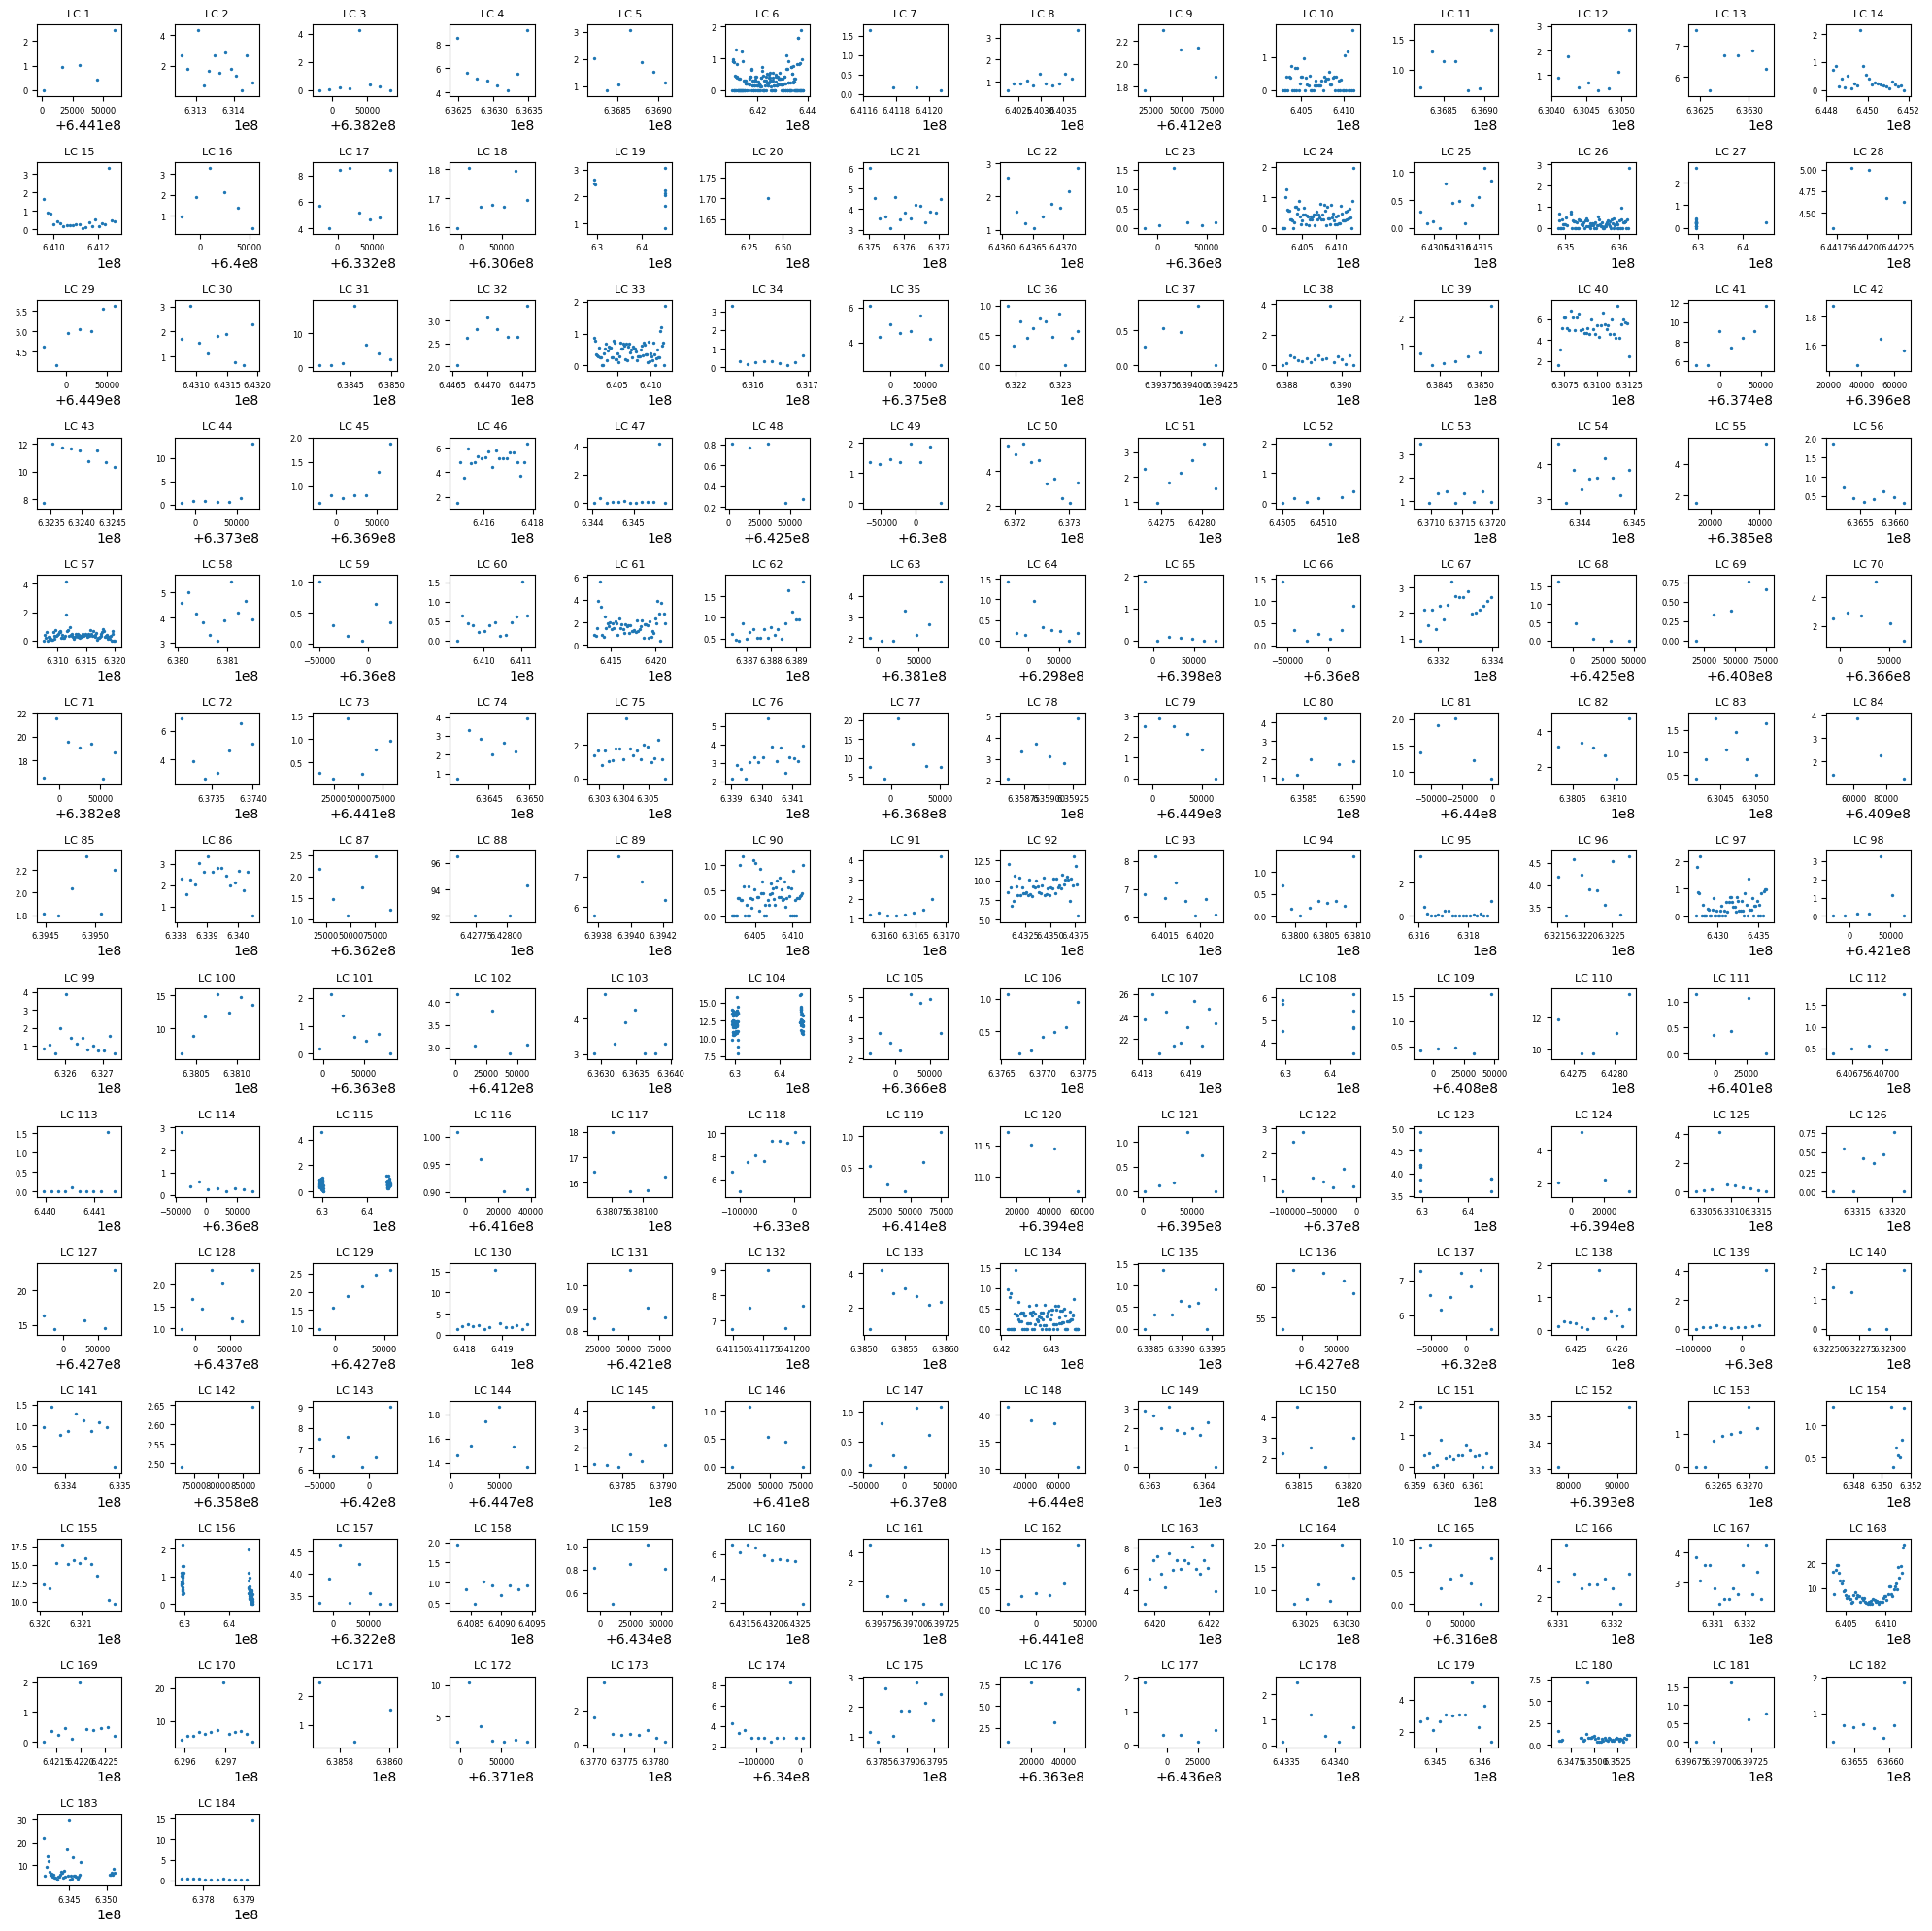

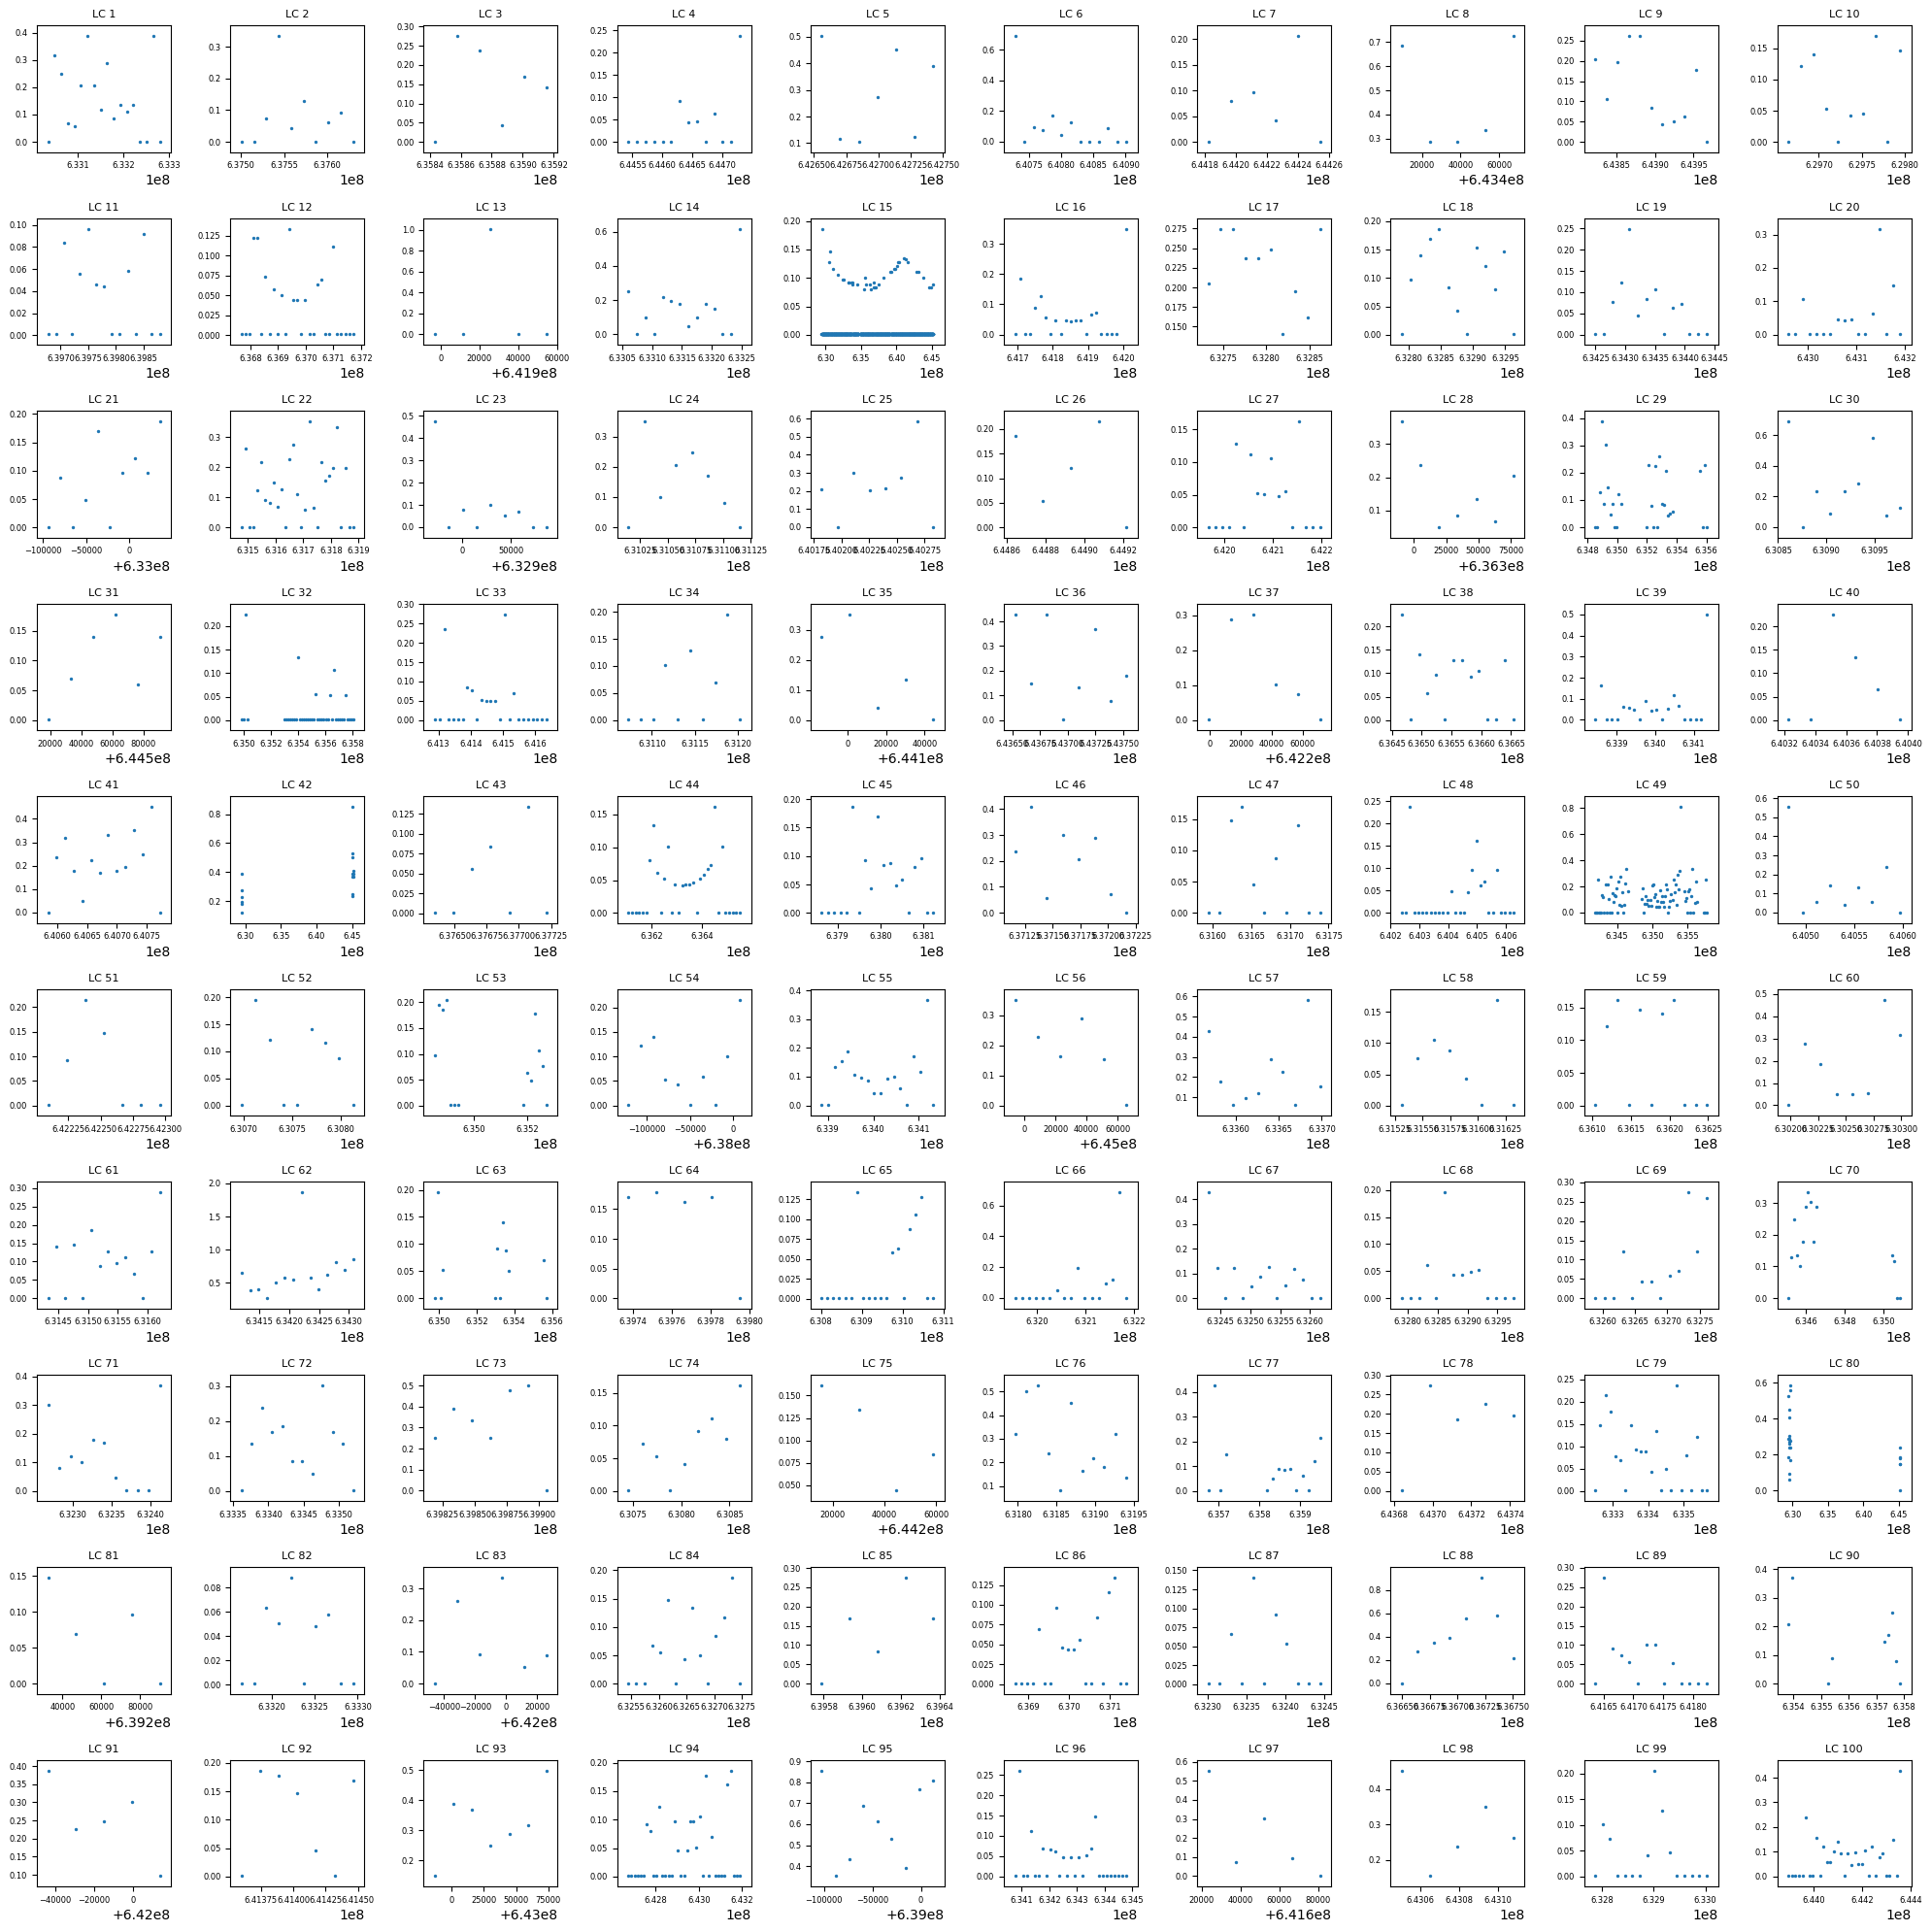

In [23]:
def plot_light_curves(light_curves, rows=10, cols=10, margin=0.1):
    """
    Plots light curves in a grid, dynamically adjusting the axis limits to reduce whitespace.
    
    Parameters:
        light_curves (list): List of Pandas DataFrames containing light curve data.
        rows (int): Number of rows in the grid.
        cols (int): Number of columns in the grid.
        margin (float): Fractional margin added around data for better visualization.
    """
    fig, axes = plt.subplots(rows, cols, figsize=(20, 20), sharex=False, sharey=False)
    axes = axes.flatten()  # Flatten the grid of axes for easy indexing

    for i, df in enumerate(light_curves):
        if i >= rows * cols:  # Stop if we exceed the grid size
            break

        ax = axes[i]
        
        # Plot the light curve -> s is the size of marker
        ax.scatter(df['TIME'], df['RATE'], s=2) 

        # Dynamically adjust axis limits
        x_min, x_max = df['TIME'].min(), df['TIME'].max()
        y_min, y_max = df['RATE'].min(), df['RATE'].max()

        # Add a margin to the limits
        x_margin = (x_max - x_min) * margin
        y_margin = (y_max - y_min) * margin

        ax.set_xlim(x_min - x_margin, x_max + x_margin)
        ax.set_ylim(y_min - y_margin, y_max + y_margin)

        # Set title and tick parameters
        ax.set_title(f"LC {i+1}", fontsize=8)
        ax.tick_params(axis='both', which='major', labelsize=6)

    # Hide unused subplots
    for j in range(i + 1, rows * cols):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()
    
# Call the plotting function
plot_light_curves(out, rows = math.ceil(math.sqrt(len(out))), cols = math.ceil(math.sqrt(len(out))))
plot_light_curves(norm[:100])


KeyError: 'RATE_ERRM'

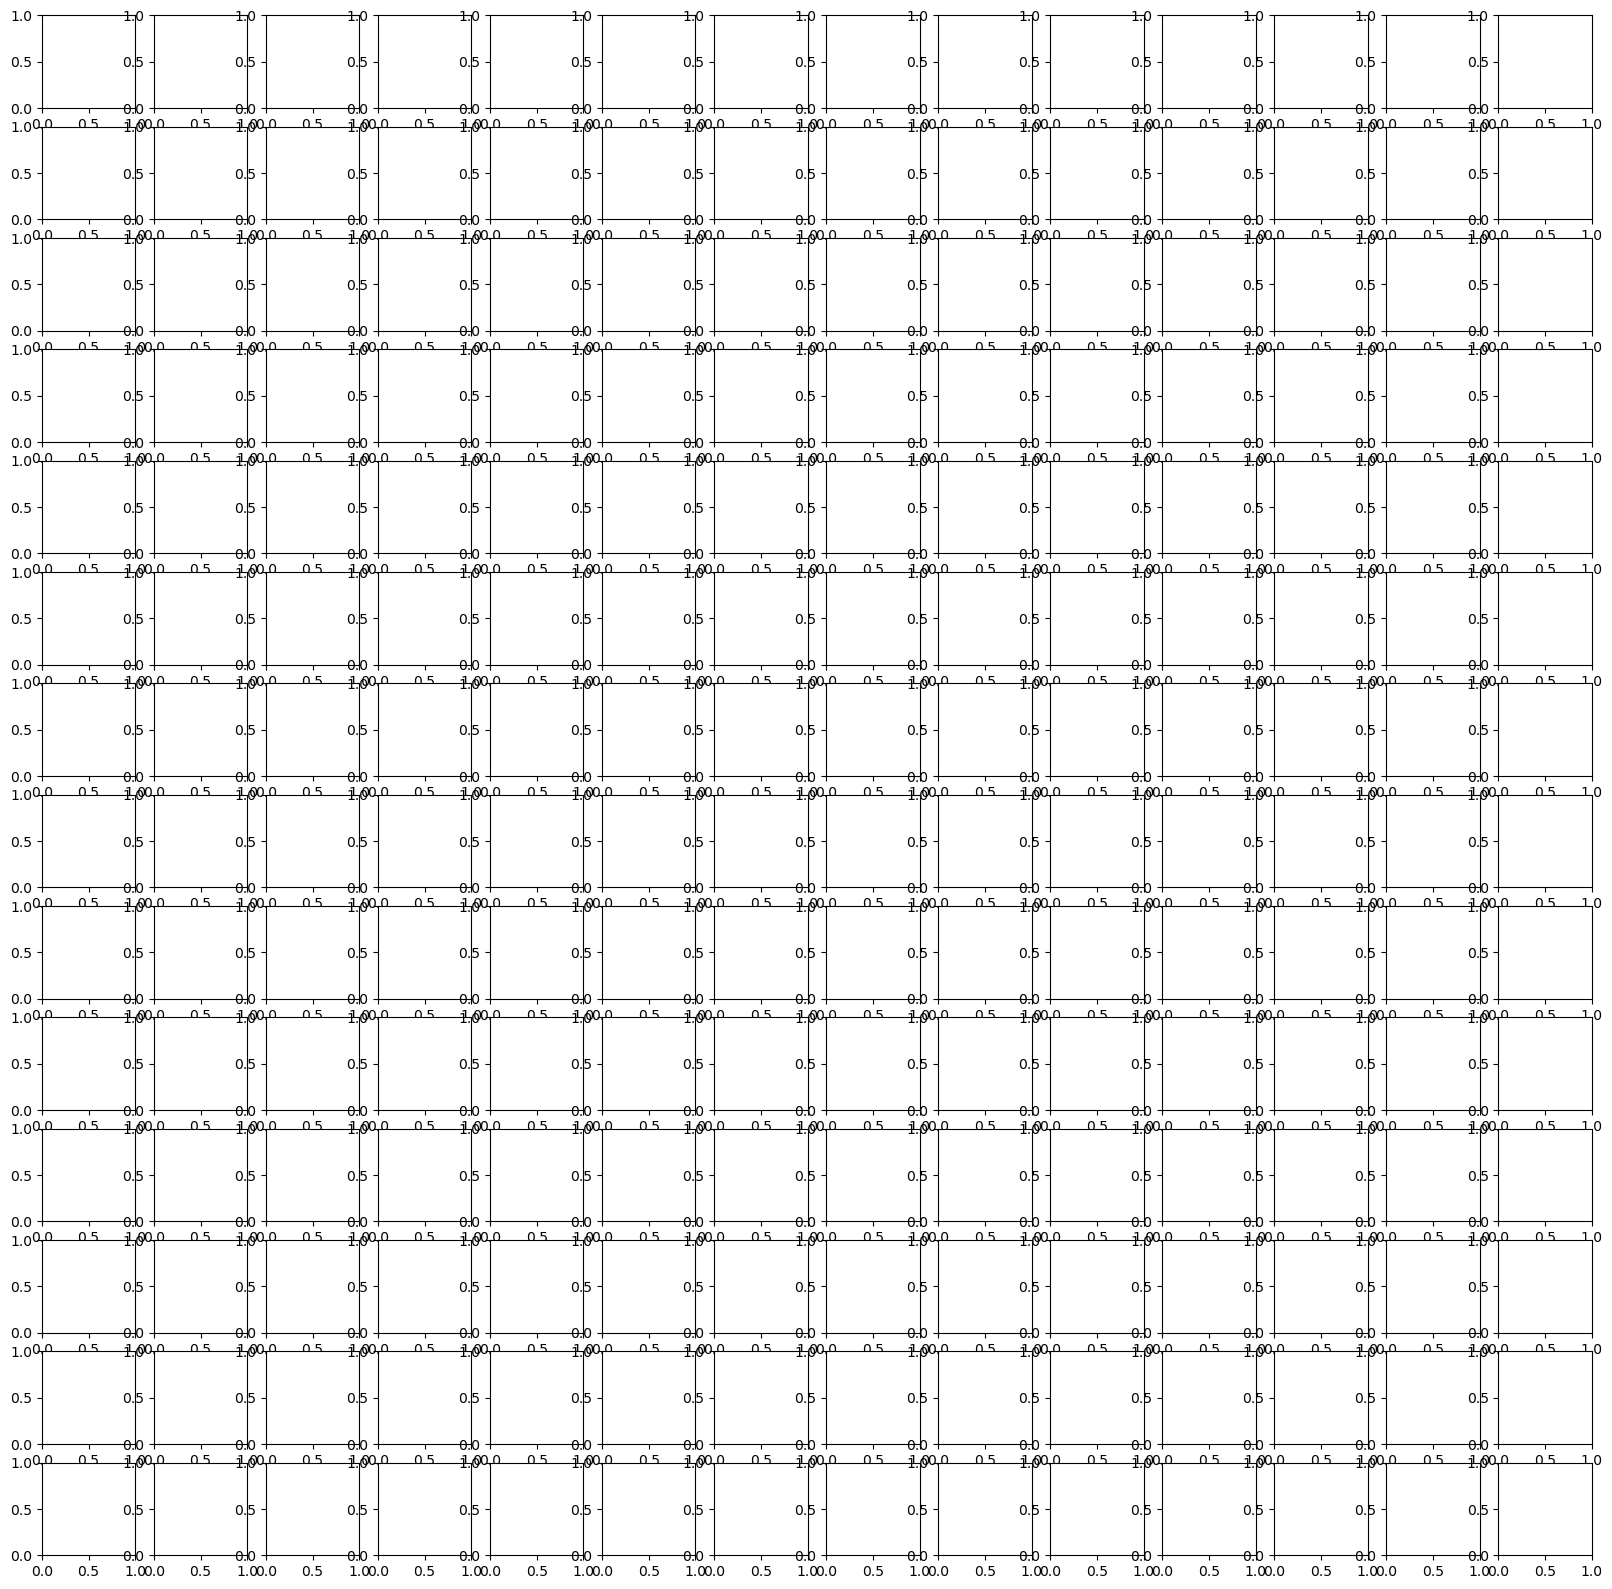

In [24]:
def plot_light_curves_error(light_curves, rows=10, cols=10, margin=0.1):
    """
    Plots light curves in a grid, dynamically adjusting the axis limits to reduce whitespace.
    
    Parameters:
        light_curves (list): List of Pandas DataFrames containing light curve data.
        rows (int): Number of rows in the grid.
        cols (int): Number of columns in the grid.
        margin (float): Fractional margin added around data for better visualization.
    """
    fig, axes = plt.subplots(rows, cols, figsize=(20, 20), sharex=False, sharey=False)
    axes = axes.flatten()  # Flatten the grid of axes for easy indexing

    for i, df in enumerate(light_curves):
        if i >= rows * cols:  # Stop if we exceed the grid size
            break

        ax = axes[i]
        
        # Plot the light curve -> s is the size of marker
        ax.errorbar(
            df['TIME'], 
            df['RATE'], 
            yerr=[df['RATE_ERRM'], df['RATE_ERRP']], #check
            fmt='o', markersize=2, label="Light Curve"
        )

        # Dynamically adjust axis limits
        x_min, x_max = df['TIME'].min(), df['TIME'].max()
        y_min, y_max = df['RATE'].min(), df['RATE'].max()

        # Add a margin to the limits
        x_margin = (x_max - x_min) * margin
        y_margin = (y_max - y_min) * margin

        ax.set_xlim(x_min - x_margin, x_max + x_margin)
        ax.set_ylim(y_min - y_margin, y_max + y_margin)

        # Set title and tick parameters
        ax.set_title(f"LC {i+1}", fontsize=8)
        ax.tick_params(axis='both', which='major', labelsize=6)

    # Hide unused subplots
    for j in range(i + 1, rows * cols):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()
    
# Call the plotting function
plot_light_curves_error(out, rows = math.ceil(math.sqrt(len(out))), cols = math.ceil(math.sqrt(len(out))))
plot_light_curves_error(norm[:100])

In [ ]:
visualize_multiple_clusters([scaled_features1, scaled_features2, scaled_features3], [outliers1, outliers2, outliers3], size=(25, 8))

In [ ]:
visualize_multiple_clusters_no_outlier([scaled_features1, scaled_features2, scaled_features3], [outliers1, outliers2, outliers3], n = len(scaled_features1), size=(25, 8))

In [ ]:
# normal = scaled_features1[~outliers]
# not_normal = scaled_features1[outliers]
# print(len(normal))
# print(len(not_normal))

In [ ]:
def analyze_feature_importance(scaled_features, outliers):
    # Calculate feature statistics for normal vs outlier groups
    normal_stats = np.mean(scaled_features[~outliers], axis=0)
    outlier_stats = np.mean(scaled_features[outliers], axis=0)
    
    # feature_names = ['Mean', 'STD', 'Skewness', 'Kurtosis', 'Max Amplitude',
    #                 'Median', 'MAD', 'IQR', 'Beyond 1-sigma', 'Flux Percentile']
    # feature_names = ['Mean', 'STD', 'Max Amplitude',
    #                 'Median', 'MAD', 'IQR', 'Beyond 1-sigma', 'Flux Percentile']
    featured_names = ["weighted_mean", "weighted-variance", "median", "iqr", "beyond_1_sigma", "mad", "skewness",
                     "kurtosis", "max_amp", "flux_percenile_ratio"]
    
    # Calculate absolute difference
    importance = np.abs(normal_stats - outlier_stats)
    
    # Create importance ranking
    ranking = np.argsort(importance)[::-1]
    
    return [(featured_names[i], importance[i]) for i in ranking]

# Plot the distributions next to each other in the isolation forest


In [ ]:
print(analyze_feature_importance(scaled_features2, outlier2))